In [1]:
from trulens_eval import TruChain, Feedback, Tru, feedback, Select

from trulens_eval.tru_custom_app import instrument
tru = Tru()


import dotenv
dotenv.load_dotenv()

from pinecone_code import PineconeServerless

Package langchain-community is installed but has a version conflict:
	(langchain-community 0.0.11 (c:\users\madhu\appdata\roaming\python\python311\site-packages), Requirement.parse('langchain_community>=0.0.17'))

This package is optional for trulens_eval so this may not be a problem but if
you need to use the related optional features and find there are errors, you
will need to resolve the conflict:

    ```bash
    pip install 'langchain_community>=0.0.17'
    ```

If you are running trulens_eval in a notebook, you may need to restart the
kernel after resolving the conflict. If your distribution is in a bad place
beyond this package, you may need to reinstall trulens_eval so that all of the
dependencies get installed and hopefully corrected:
    
    ```bash
    pip uninstall -y trulens_eval
    pip install trulens_eval
    ```



Using legacy llama_index version None. Consider upgrading to 0.10.0 or later.


🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of Tru` to prevent this.


In [2]:
#prompt = "You are a chatbot build to answer questions about the meeting. You will receive relevent meeting transcript. You should understand the transcript and answer the user query. You can ask questions to the user and answer their questions based on the context provided."
#prompt = "You are a chatbot build to answer questions about the meeting. You will refrain answering questions for which the context is not provided. You will answer the questions solely based on the context provided. You can ask questions to the user and answer their questions based on the context provided."
prompt  = "You are a friendly chat model. You will respond to the user's message using only the context provided. The context can be anything from a single message to a whole conversation. You can also ask questions to the user."
#prompt = "You are a friendly chatbot build to answer questions about the meeting. You will be benalized if you answer questions for which the context is not provided. You will answer the questions solely based on the context provided. You can ask questions to the user and answer their questions based on the context provided."
#prompt = "You are provided the meeting transcript file. The data includes meeting speaker, time of the conversation and the conversation text. Your job is to answer user questions based on the context provided. You can ask questions to the user and answer their questions based on the context provided."
#prompt = "Youa re a professional chat bot. You will answer the user's questions based on the context provided. You can ask questions to the user and answer their questions based on the context provided. You will refrain from answering questions for which the context is not provided. If the context is not clear, you will ask the user for more information. You will be penalized if you answer questions for which the context is not provided."

In [20]:
from openai import OpenAI
oai_client = OpenAI()

oai_client.embeddings.create(
        model="text-embedding-ada-002",
        input=prompt,
    )

CreateEmbeddingResponse(data=[Embedding(embedding=[-0.02812923863530159, 0.008014813996851444, 0.0110767288133502, -0.017456278204917908, -0.009064613841474056, 0.01981159672141075, -0.02820999175310135, -0.005037018097937107, -0.010767173022031784, -0.022436095401644707, -0.008849269710481167, 0.009818315505981445, -0.00585128553211689, -0.01360701397061348, -0.013035008683800697, -0.0370929092168808, 0.018573373556137085, -0.012866770848631859, 0.01565277762711048, -0.019650090485811234, -0.01581428386271, 0.0039569358341395855, -0.010275919921696186, -0.0022526944521814585, -0.019959645345807076, 0.0006334125646390021, 0.0049394406378269196, -0.010026929900050163, -0.008304181508719921, -0.027644716203212738, -0.014589519239962101, 0.004959628917276859, -0.0007183722918853164, -0.03111712820827961, 0.0015494634862989187, 0.01241589616984129, 0.009542406536638737, 0.0059656864032149315, 0.02912520244717598, 0.019475122913718224, 0.03203233703970909, 0.017187099903821945, -0.007772552

In [3]:
import google.generativeai as genai
import os
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
model = genai.GenerativeModel('gemini-pro')

In [4]:
def parse_conversations(conversations) -> str:
    data = []
    for cluster_id, cluster_df in conversations.items():
        for i, row in cluster_df.iterrows():
            data.append(
                f"{row['start_time']} - {row['speaker']}: {row['text']}"
            )
        data.append("\n\n")
    data = "\n".join(data)
    return data

In [7]:
class RAG_from_scratch:
    @instrument
    def retrieve(self, query: str, in_filter: list) -> list:
        """
        Retrieve relevant text from vector store.
        """
        obj1 = PineconeServerless()
        response1 = obj1.query_pinecone(query, in_filter)
        conversation1_df = obj1.query_delta_conversations()
        #text_list = list(conversation1_df)
        context = parse_conversations(conversation1_df)
        return context
    
    @instrument
    def generate_completion(self, query: str, context_str) -> str:
        """
        Generate answer from context.
        """
        completion = model.generate_content(f"[We have provided context information below.{context_str}Given this information, please answer the question: {query}]",safety_settings={'HARASSMENT':'block_none','HARM_CATEGORY_HARASSMENT':'block_none', 'HARM_CATEGORY_HATE_SPEECH':'block_none', 'HARM_CATEGORY_SEXUALLY_EXPLICIT':'block_none', 'HARM_CATEGORY_DANGEROUS_CONTENT':'block_none'})
        print(completion.prompt_feedback)
        return completion.text
        # completion = oai_client.chat.completions.create(
        # model="gpt-3.5-turbo",
        # temperature=0,
        # messages=
        # [
        #     {"role": "user",
        #     "content": 
        #     f"We have provided context information below. \n"
        #     f"---------------------\n"
        #     f"{context_str}"
        #     f"\n---------------------\n"
        #     f"Given this information, please answer the question: {query}"
        #     }
        # ]
        # ).choices[0].message.content
        # return completion
        

    @instrument
    def query(self, query: str, in_filter:list) -> str:
        context_str = self.retrieve(query, in_filter)
        print("CONTEXT ",context_str)
        completion = self.generate_completion(query, context_str)
        return completion,context_str

rag = RAG_from_scratch()

In [8]:
from trulens_eval import Feedback, Select
from trulens_eval.feedback import Groundedness
from trulens_eval.feedback.provider.openai import OpenAI as fOpenAI

import numpy as np
# Initialize provider class
fopenai = fOpenAI()

grounded = Groundedness(groundedness_provider=fopenai)

# Define a groundedness feedback function
f_groundedness = (
    Feedback(grounded.groundedness_measure_with_cot_reasons, name = "Groundedness")
    .on(Select.RecordCalls.retrieve.rets.collect())
    .on_output()
    .aggregate(grounded.grounded_statements_aggregator)
)

# Question/answer relevance between overall question and answer.
f_qa_relevance = (
    Feedback(fopenai.relevance_with_cot_reasons, name = "Answer Relevance")
    .on(Select.RecordCalls.retrieve.args.query)
    .on_output()
)

# Question/statement relevance between question and each context chunk.
f_context_relevance = (
    Feedback(fopenai.qs_relevance_with_cot_reasons, name = "Context Relevance")
    .on(Select.RecordCalls.retrieve.args.query)
    .on(Select.RecordCalls.retrieve.rets.collect())
    .aggregate(np.mean)
)

✅ In Groundedness, input source will be set to __record__.app.retrieve.rets.collect() .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Answer Relevance, input prompt will be set to __record__.app.retrieve.args.query .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input question will be set to __record__.app.retrieve.args.query .
✅ In Context Relevance, input statement will be set to __record__.app.retrieve.rets.collect() .


In [9]:
from trulens_eval import TruCustomApp
tru_rag = TruCustomApp(rag,
    app_id = 'RAG v1',
    feedbacks = [f_groundedness, f_qa_relevance, f_context_relevance])

Function <function RAG_from_scratch.retrieve at 0x00000236C6A5FC40> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_from_scratch object at 0x000002368378B950> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_from_scratch.query at 0x0000023684B7DC60> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_from_scratch object at 0x000002368378B950> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_from_scratch.query at 0x00000236C6ABC2C0> was not found during instrumentation walk. Make sure it is accessible by traversing app <__main__.RAG_from_scratch object at 0x000002368378B950> or provide a bound method for it as TruCustomApp constructor argument `methods_to_instrument`.
Function <function RAG_from_scratch.retrieve at 0x0000023684B7DB20> was not found 

In [10]:
# if testing with clustering 
#in_filter = ['a4454589-6c49-4d8d-a6f6-c2b5c99ef229', '7c3c7ac7-94ee-4045-b94a-e9b1695c5b7e']
in_filter = []  #if not using clustering

In [11]:

import pandas as pd 
questions= pd.read_csv("Questions.csv")
queries = questions['Question']

ground_truths = questions['Groundtruth']
qna = []

In [12]:
queries=queries.to_list()
ground_truths=ground_truths.to_list()

In [13]:
for query in queries:
    with tru_rag as recording:
        completion,context = rag.query(query, in_filter)
        print(completion)
        qna.append([query, completion, ground_truths[queries.index(query)], context])

last_conversation_no fetched from master json:  20207
conversation length:  3
LENGTH delta_conversation_df:  15
CONTEXT  00:15:35 - spk_6: social media has changed your
00:15:36 - spk_0: life 100%? I dont think I would be the person I am if it wasnt for social media. I first came out on Tik Tok and my parents didnt even know thats how they found out. Actually,
00:15:47 - spk_6: Children under the age of 13 should not be allowed on social media.
00:15:58 - spk_5: Well, um its kind of funny because I talked to a lot of organizations with log off. And the main point that they try to get across is that theyre trying to advocate for kids to get cell phones and technology and social media at an older age. Um, and, you know, years ago I would have said thats really stupid. Thats like the drug talk, like, dont do drugs, dont be on social media. Im not gonna listen to that. But then after years of kind of self reflection, I wish someone would have said you dont need Instagram to have a social  

Unsure what the main input string is for the call to query with args ['What is a common recommendation regarding the age limit for children on social media platforms?', []].


safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: LOW
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: MEDIUM
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

Many advocate for an older age limit for children to use social media platforms, such as 16 or 18 years old.
last_conversation_no fetched from master json:  20207
conversation length:  3
LENGTH delta_conversation_df:  15
CONTEXT  00:09:05 - spk_0: Even if youre not on social media, you know, its gonna do that anyway. Like if youre searching anything on, like if youre searching something up on safari and you go onto your computer onto Chrome, the ads will probably be the same, you know, its just,  its just technology,
 you know.
00:09:17 - spk_1: Um I sat down here saying that social media makes people antisocial. But hearing Alexa and Alex speak, it makes me 

Unsure what the main input string is for the call to query with args ['What was discussed about cyberbullying?', []].


safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: HIGH
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: MEDIUM
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

Cyberbullying was discussed as a harmful and pervasive issue that can have serious consequences for young people. It was noted that cyberbullying can take many forms, including online harassment, threats, and the dissemination of embarrassing or private information. The speakers shared their own experiences with cyberbullying and discussed the emotional distress and psychological harm it can cause. They also emphasized the importance of seeking help if you are being cyberbullied and the need for schools and communities to take action to address this issue.
last_conversation_no fetched from master json:  20207
conversation length:  3
LENGTH delta_conversation

Unsure what the main input string is for the call to query with args ['Did they talk about social media and eating disorder?', []].


safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: MEDIUM
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: MEDIUM
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

Yes, they talked about social media and eating disorder. Specifically, spk_4 mentioned that on social media, someone might talk about their eating disorder, depression, and give real advice that a school really can never do.
last_conversation_no fetched from master json:  20207
conversation length:  3
LENGTH delta_conversation_df:  15
CONTEXT  00:04:09 - spk_2: So we only get one printer for 15 people.
00:04:12 - spk_1: Um, well, we get one sort of networked printer and then I think some of us have personal printers. I think Susan has a personal printer. Gisella has one. Maybe I cant remember who else. Yeah. But no one else gets their own printer in terms 

Unsure what the main input string is for the call to query with args ['Do people need a reading room?', []].


safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

Yes, many people want to have a reading room.
last_conversation_no fetched from master json:  20207
conversation length:  3
LENGTH delta_conversation_df:  15
CONTEXT  00:14:37 - spk_1: Yeah, I think everybody agrees on that. One person will be too small. Anyways. How about, how about this room?
00:14:44 - spk_2: The bottom? Yeah, a t the bottom in the middle with, due to the mountains? Yeah,  it has three windows. So I think its, uh,
 22. Well, which
00:14:53 - spk_1: w theres 32 person rooms,
00:14:55 - spk_2: the, the middle one  that
 has two windows. Yeah,
00:14:59 - spk_1: its, which is fine.  Its still a
 big room. Big black stripe is the win

Unsure what the main input string is for the call to query with args ['Whats the maximum capacity of the rooms?', []].


safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

32
last_conversation_no fetched from master json:  20207
conversation length:  3
LENGTH delta_conversation_df:  15
CONTEXT  00:25:25 - spk_1: Is the heart of the
00:25:27 - spk_3: heart of the,
00:25:29 - spk_2: and since you n you will meet the administrator. Can we ask for a coffee machine somewhere
00:25:37 - spk_3:  in the reading room? That would be
 good.
00:25:39 - spk_2: Yeah. Or in that hall? I mean the sixth floor, theres no coffee machine.
00:25:44 - spk_0: Its, you mean like  a little machine
 or a vending
00:25:49 - spk_2: a vending machine?



00:31:25 - spk_1:  We can bring your coffee in the reading
 room and
00:31:28 - spk_2: buyin

Unsure what the main input string is for the call to query with args ['Is there a coffee machine on the sixth floor of the office?', []].


safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

No
last_conversation_no fetched from master json:  20207
conversation length:  3
LENGTH delta_conversation_df:  15
CONTEXT  00:24:18 - spk_1: East anyways
00:24:22 - spk_0: anyways
00:24:23 - spk_1: this office, right?
00:24:26 - spk_0: You know, because with mountain mountains and old town its not. No, sorry. But
00:24:32 - spk_1: Im very bad at orienting. Whereas North in Geneva, I always get it wrong. But I just assumed Nicos was talking with orientation here. Sunrise and sunshine is quite



00:05:20 - spk_3: how we can, who we gonna put in the three person rooms. I mean, we have now, uh, 23 person rooms left. And, um,
00:05:32 - spk_2: no, no,

Unsure what the main input string is for the call to query with args ['Is there air conditioning in the office?', []].


safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

The provided information does not specify whether there is air conditioning in the office.


Error calling wrapped function query.
Traceback (most recent call last):
  File "C:\Users\madhu\AppData\Roaming\Python\Python311\site-packages\trulens_eval\instruments.py", line 733, in tru_wrapper
    rets, cost = Endpoint.track_all_costs_tally(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\madhu\AppData\Roaming\Python\Python311\site-packages\trulens_eval\feedback\provider\endpoint\base.py", line 496, in track_all_costs_tally
    result, cbs = Endpoint.track_all_costs(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\madhu\AppData\Roaming\Python\Python311\site-packages\trulens_eval\feedback\provider\endpoint\base.py", line 465, in track_all_costs
    e = cls()
        ^^^^^
  File "C:\Users\madhu\AppData\Roaming\Python\Python311\site-packages\trulens_eval\feedback\provider\endpoint\openai.py", line 243, in __init__
    client = oai.OpenAI(**kwargs)
             ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\madhu\AppData\Roaming\Python\Python311\site-packages\op

KeyboardInterrupt: 

In [42]:
for q,a,con,gt in qna:
    print(f"Query: {q}\nAnswer: {a}\nContext: {con}", f"\nGround Truth: {gt}\n\n")

Query: What is a common recommendation regarding the age limit for children on social media platforms?
Answer: A common recommendation regarding the age limit for children on social media platforms is that children under the age of 13 should not be allowed on social media. Some individuals believe that children should be older before they are given access to cell phones, technology, and social media platforms. However, others argue that children are relentless and will find a way to access social media regardless of age restrictions. Ultimately, the discussion highlights the importance of education and teaching children about responsible technology use.
Context: Children under the age of 13 should not be allowed on social media. 
Ground Truth: 00:15:35 - spk_6: social media has changed your
00:15:36 - spk_0: life 100%? I dont think I would be the person I am if it wasnt for social media. I first came out on Tik Tok and my parents didnt even know thats how they found out. Actually,
00:1

In [43]:
import pandas as pd
res = pd.DataFrame(qna, columns = ['Query', 'Answer', 'Ground Truth','Context'])
res.to_csv('rag_results_gpt.csv', index = False)

In [44]:
results_df=tru.get_records_and_feedback(app_ids=["RAG v1"])[0]

In [45]:
results_df.to_csv("gpt_results.csv")

In [225]:
results_df.columns

Index(['app_id', 'app_json', 'type', 'record_id', 'input', 'output', 'tags',
       'record_json', 'cost_json', 'perf_json', 'ts', 'Groundedness',
       'Answer Relevance', 'Context Relevance', 'Groundedness_calls',
       'Answer Relevance_calls', 'Context Relevance_calls', 'latency',
       'total_tokens', 'total_cost'],
      dtype='object')

In [226]:
results_df = results_df.loc[:,['record_id','input','output','Groundedness','Answer Relevance','Context Relevance','latency','total_tokens','total_cost']].copy()

In [ ]:
results_df

In [228]:
results_df.to_csv("gpt_results.csv")

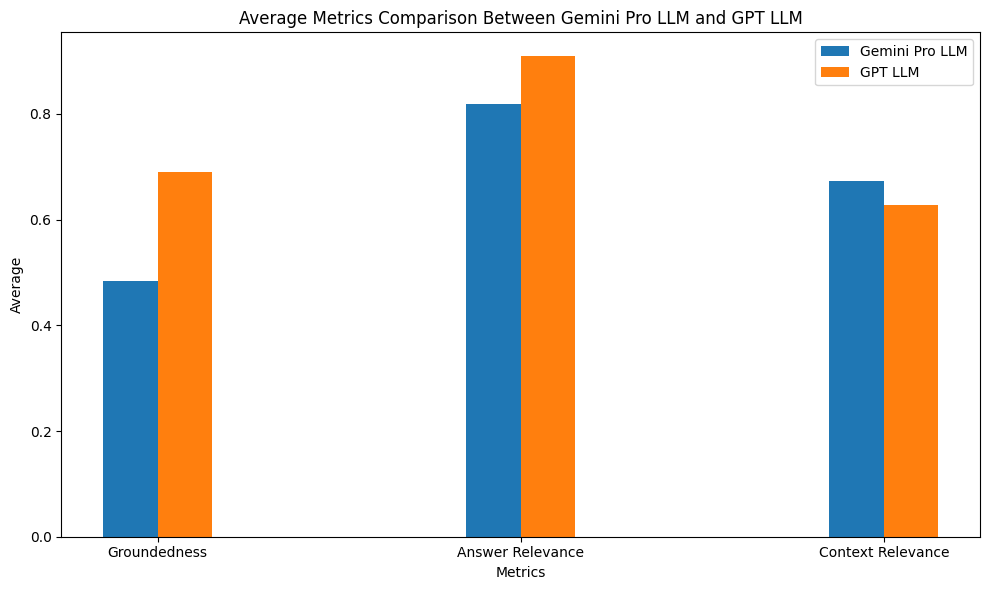

In [54]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


gemini_pro_llm_data = pd.read_csv('gemini_pro_results.csv')
gpt_llm_data = pd.read_csv('gpt_results.csv')

gemini_pro_llm_avg = gemini_pro_llm_data[['Groundedness', 'Answer Relevance', 'Context Relevance']].mean()


gpt_llm_avg = gpt_llm_data[['Groundedness', 'Answer Relevance', 'Context Relevance']].mean()


labels = ['Groundedness', 'Answer Relevance', 'Context Relevance']
gemini_pro_llm_values = gemini_pro_llm_avg.values
gpt_llm_values = gpt_llm_avg.values

x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, gemini_pro_llm_values, width, label='Gemini Pro LLM')
rects2 = ax.bar(x + width/2, gpt_llm_values, width, label='GPT LLM')

ax.set_xlabel('Metrics')
ax.set_ylabel('Average')
ax.set_title('Average Metrics Comparison Between Gemini Pro LLM and GPT LLM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()




fig.tight_layout()
plt.savefig("LLM_Comparision.png")
plt.show()



In [ ]:
# #evaluating questions and answers uby finding cosine similarity between the question and the answer

# from sentence_transformers import SentenceTransformer, util
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# def get_similarity_score(query, answer):
#     query_embedding = model.encode(query, convert_to_tensor=True)
#     answer_embedding = model.encode(answer, convert_to_tensor=True)
#     cosine_scores = util.pytorch_cos_sim(query_embedding, answer_embedding)
#     return cosine_scores.item()

# # for q,a in qna:
# #     print(f"Query: {q}\nAnswer: {a}\nSimilarity Score: {get_similarity_score(q,a)}\n\n")
    
# res['Query_Answer Similarity Score'] = res.apply(lambda x: get_similarity_score(x['Query'], x['Answer']), axis=1)    
# res['Answer_Ground Truth Similarity Score'] = res.apply(lambda x: get_similarity_score(x['Ground Truth'], x['Answer']), axis=1) 


In [ ]:
# EXTRA EVAL: ROGUE

In [ ]:
# Getting thr context from the conversation that was received from the Pinecone

obj2 = PineconeServerless()

str_list = []
for q, _, _ in qna:
    response2 = obj2.query_pinecone(q, in_filter)
    conversation1_df = obj2.query_delta_conversations()
    text_list = list(conversation1_df['text'])
    str_text = ' '.join(text_list)
    str_list.append(str_text)


res['Context'] = str_list

In [ ]:
from rouge import Rouge

rouge = Rouge()
def get_rouge_score(generated_summary, reference_summary):
    scores = rouge.get_scores(generated_summary, reference_summary, avg=True)
    return scores

# for i in range(len(res)):
#     print(f"Query: {res['Query'][i]}\nAnswer: {res['Answer'][i]}\nROUGE Score: {get_rouge_score(res['Answer'][i], res['Context'][i])}\n\n")

res['ROUGE Score'] = res.apply(lambda x: get_rouge_score(x['Answer'], x['Ground Truth']), axis=1)


In [ ]:
for i in range(len(res)):
    print(f"Query: {res['Ground Truth'][i]}\nAnswer: {res['Answer'][i]}\nROUGE Score: {get_rouge_score(res['Answer'][i], res['Ground Truth'][i])}\n\n")


In [151]:
# Dashboard
tru.run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


ModuleNotFoundError: 
ipython,ipywidgets packages are required for using trulens_eval in a notebook.
You should be able to install them with pip:

    ```bash
    pip install "ipython>=8.12.0" "ipywidgets>=8.0.6"
    ```


In [ ]:
'''
ROUGE-1:
r: Recall. It measures the overlap of unigrams (single words) between the generated answer and the reference answer. 
p: Precision. It measures the percentage of unigrams in the generated answer that are also present in the reference answer. 
f: F1 Score. It is the harmonic mean of precision and recall. It provides a balance between precision and recall.

ROUGE-2:
r: Recall. It measures the overlap of bigrams (sequences of two words) between the generated answer and the reference answer. 
p: Precision. It measures the percentage of bigrams in the generated answer that are also present in the reference answer.
f: F1 Score. It represents the overall performance of the ROUGE-2 metric.

ROUGE-L:
r: Recall. It measures the longest common subsequence of words between the generated answer and the reference answer. 
p: Precision. It measures the percentage of words in the generated answer that are also present in the reference answer. 
f: F1 Score. It represents the overall performance of the ROUGE-L metric.

'''

In [ ]:
# RUNS THE DASHBOARD
tru.run_dashboard()